# Game of Thrones End-To-End Notebook

This notebook contains an end-to-end workflow using a single csv file of Game of Thrones battle data.

In [1]:
import os
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.discovery import Discovery
from neo4j_runway import GraphDataModeler
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.ingestion import PyIngest

## Read Data

In [2]:
data_dictionary = load_data_dictionary_from_yaml("data_dictionary.yaml")
data_dictionary

{'name': 'The name of the battle.',
 'year': 'The year the battle took place.',
 'battle_number': 'A unique ID for the battle.',
 'king': 'A king participating in the battle.',
 'outcome': 'Whether the battle was won or lost.',
 'family': 'A significant family in the battle.',
 'size': 'The size of the army.',
 'summer': 'Whether the battle took place during Summer.',
 'location': 'The location of the battle.',
 'region': 'The larger region a battle took place in.',
 'commander': 'The commander leading an army in the battle.',
 'attacking': 'Whether the army is attacking or not.'}

In [3]:
data_directory = "../../../data/got/"
file_name = "game_of_thrones_battles.csv"
data = load_local_files(data_directory=data_directory, 
                        general_description="This file contains data on game of thrones battles", 
                        data_dictionary=data_dictionary, 
                        use_cases=["What families have changed alliances?", "how have army sizes changed over time?", "Which families attack most often?"],
                        ignored_files=["got-battles.csv", "_.ipynb"])

In [4]:
data.data[0].data

,name,year,battle_number,king,outcome,family,size,summer,location,region,commander,attacking
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Golden Tooth,The Westerlands,Jaime Lannister,True
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,True,Lannister,NaN,True,Mummer's Ford,The Riverlands,Gregor Clegane,True
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Riverrun,The Riverlands,Jaime Lannister,True
3,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Riverrun,The Riverlands,Andros Brax,True
4,Battle of the Green Fork,298,4,Robb Stark,False,Stark,18000.0,True,Green Fork,The Riverlands,Roose Bolton,True
...,...,...,...,...,...,...,...,...,...,...,...,...
179,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Stannis Baratheon,False
180,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Jon Snow,False
181,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Donal Noye,False
182,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Cotter Pyke,False


## Discovery

In [5]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini")
disc = Discovery(llm=disc_llm, data=data)

In [6]:
disc.run()

### Preliminary Analysis of Game of Thrones Battles Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 184 entries and 12 columns, indicating a moderate size for analysis.
2. **Data Types**: The features include a mix of categorical (object), numerical (int64, float64), and boolean data types. This diversity allows for various types of analyses.
3. **Missing Values**: Some columns have missing values:
   - `king`: 4 missing values
   - `outcome`: 6 missing values
   - `size`: 36 missing values
   - `summer`: 3 missing values
   - `location`: 2 missing values
   - `commander`: 10 missing values
   Handling these missing values will be crucial for accurate analysis.

#### Key Features:
1. **Year**: The battles occurred predominantly in the year 299, with a few in 298 and 300. This indicates a limited time frame for the battles, which may affect the analysis of trends over time.
2. **Battle Number**: This feature serves as a unique identifier for each battle, which is essential for tracking individual battles and their characteristics.
3. **Size**: The army size varies significantly, with a mean of approximately 16,831 and a maximum of 100,000. The large standard deviation suggests a wide range of army sizes, which could be important for analyzing battle outcomes and strategies.
4. **King**: The presence of only 6 unique kings indicates a concentration of power among a few individuals, which may influence alliance changes and battle outcomes.
5. **Outcome**: The outcome feature is binary (won/lost) and has some missing values. This is crucial for understanding the effectiveness of different families and commanders in battles.
6. **Family**: With 21 unique families, this feature is vital for analyzing alliances and conflicts. The most frequent family is the Lannisters, which may indicate their prominence in battles.
7. **Location and Region**: The battles took place in various locations and regions, with some locations being more frequent than others (e.g., Castle Black). This can help in understanding geographical strategies and family dominance in specific areas.
8. **Commander**: The commander feature has 81 unique entries, indicating a diverse range of leaders. The most frequent commander is Stannis Baratheon, which may suggest his importance in the battles.

#### Use Case Insights:
1. **Families Changing Alliances**: The `family` and `king` features can be analyzed together to identify patterns of alliances and conflicts. By examining the battles won/lost by each family, we can infer changes in alliances over time.
2. **Army Size Changes Over Time**: The `year` and `size` features can be correlated to analyze trends in army sizes. This can reveal whether armies have grown or shrunk over the years and how this correlates with battle outcomes.
3. **Most Frequent Attackers**: The `family` and `attacking` features can be used to determine which families are involved in the most battles. This can help identify aggressive families and their strategies.

### Conclusion:
The dataset provides a rich source of information for analyzing battles in the Game of Thrones universe. Key features such as `family`, `size`, `year`, and `outcome` will be instrumental in addressing the use cases. However, attention must be given to the missing values and the limited time frame of the battles.

In [7]:
disc.to_markdown(file_dir="./outputs/")

## Data Modeling

In [8]:
gdm_llm = OpenAIDataModelingLLM(model_name="gpt-4o")
gdm = GraphDataModeler(llm=gdm_llm, discovery=disc)

In [9]:
gdm.create_initial_model(max_retries=3)

Entity Pool Generation Attempt: 1

 Please generate a pool of entities that will be used to construct a graph data model. Here are the initial discovery findings:
### Preliminary Analysis of Game of Thrones Battles Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 184 entries and 12 columns, indicating a moderate size for analysis.
2. **Data Types**: The features include a mix of categorical (object), numerical (int64, float64), and boolean data types. This diversity allows for various types of analyses.
3. **Missing Values**: Some columns have missing values:
   - `king`: 4 missing values
   - `outcome`: 6 missing values
   - `size`: 36 missing values
   - `summer`: 3 missing values
   - `location`: 2 missing values
   - `commander`: 10 missing values
   Handling these missing values will be crucial for accurate analysis.

#### Key Features:
1. **Year**: The battles occurred predominantly in the year 299, with a few in 298 and 300. This indicates a limite

DataModel(nodes=[Node(label='Battle', properties=[Property(name='name', type='str', column_mapping='name', alias=None, is_unique=True, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='battleNumber', type='int', column_mapping='battle_number', alias=None, is_unique=True, part_of_key=False), Property(name='outcome', type='str', column_mapping='outcome', alias=None, is_unique=False, part_of_key=False), Property(name='size', type='int', column_mapping='size', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False), Property(name='location', type='str', column_mapping='location', alias=None, is_unique=False, part_of_key=False), Property(name='region', type='str', column_mapping='region', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='King', properties=[Property(na

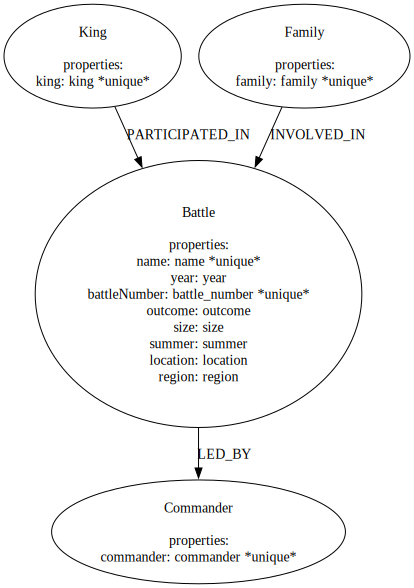

In [10]:
gdm.current_model.visualize()

In [11]:
corrections = "Create separate nodes for location and region. Add an attacking boolean property to PARTICPATED_IN and INVOLVED_IN"
gdm.iterate_model(corrections=corrections, max_retries=3)


 Please make corrections to the graph data model using the context provided. Here are the initial discovery findings:
### Preliminary Analysis of Game of Thrones Battles Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 184 entries and 12 columns, indicating a moderate size for analysis.
2. **Data Types**: The features include a mix of categorical (object), numerical (int64, float64), and boolean data types. This diversity allows for various types of analyses.
3. **Missing Values**: Some columns have missing values:
   - `king`: 4 missing values
   - `outcome`: 6 missing values
   - `size`: 36 missing values
   - `summer`: 3 missing values
   - `location`: 2 missing values
   - `commander`: 10 missing values
   Handling these missing values will be crucial for accurate analysis.

#### Key Features:
1. **Year**: The battles occurred predominantly in the year 299, with a few in 298 and 300. This indicates a limited time frame for the battles, which may affe

DataModel(nodes=[Node(label='Battle', properties=[Property(name='name', type='str', column_mapping='name', alias=None, is_unique=True, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='battleNumber', type='int', column_mapping='battle_number', alias=None, is_unique=True, part_of_key=False), Property(name='outcome', type='str', column_mapping='outcome', alias=None, is_unique=False, part_of_key=False), Property(name='size', type='int', column_mapping='size', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='King', properties=[Property(name='king', type='str', column_mapping='king', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, is

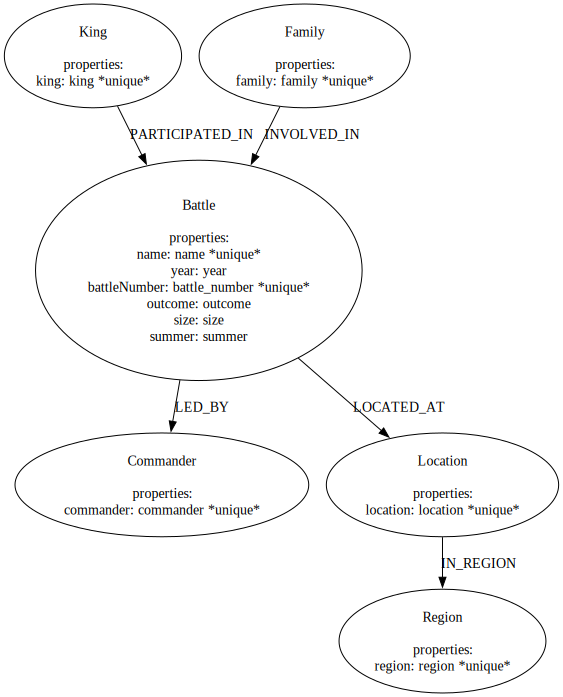

In [12]:
gdm.current_model.visualize()

## Code Generation

In [19]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, database="gameofthrones", username="neo4j", uri=os.environ.get("NEO4J_URI"), password=os.environ.get("NEO4J_PASSWORD"), source_name=file_name, file_directory=data_directory)

In [20]:
gen.generate_config_yaml(file_name="./outputs/config.yaml")

## Ingest

In [21]:
PyIngest(config=gen.generate_config_string())

File {} .//../../../data/got/game_of_thrones_battles.csv
.//../../../data/got/game_of_thrones_battles.csv 0 2024-09-05 08:26:27.499829
.//../../../data/got/game_of_thrones_battles.csv 1 2024-09-05 08:26:27.775536
{} : Completed file 2024-09-05 08:26:27.807759
File {} .//../../../data/got/game_of_thrones_battles.csv
.//../../../data/got/game_of_thrones_battles.csv 0 2024-09-05 08:26:27.809431
.//../../../data/got/game_of_thrones_battles.csv 1 2024-09-05 08:26:27.841938
{} : Completed file 2024-09-05 08:26:27.855417
File {} .//../../../data/got/game_of_thrones_battles.csv
.//../../../data/got/game_of_thrones_battles.csv 0 2024-09-05 08:26:27.857019
.//../../../data/got/game_of_thrones_battles.csv 1 2024-09-05 08:26:27.886940
{} : Completed file 2024-09-05 08:26:27.900378
File {} .//../../../data/got/game_of_thrones_battles.csv
.//../../../data/got/game_of_thrones_battles.csv 0 2024-09-05 08:26:27.901734
.//../../../data/got/game_of_thrones_battles.csv 1 2024-09-05 08:26:27.949746
{} : Co